In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from astropy.table import Table
from astropy.io import fits

### Handy functions and globals

In [2]:
nnpz_dir = '/home/aalvarez/Work/Projects/NNPZ'
nnpz_bin = os.path.join(nnpz_dir, 'bin', 'nnpz')
nnpzphoto_bin = os.path.join(nnpz_dir, 'bin', 'NnpzBuildPhotometry')
reference_sample = '/home/aalvarez/Work/Data/dc3/ReferenceSample'
nnpz_env = os.environ.copy()
nnpz_env['PYTHONPATH'] = nnpz_env.get('PYTHONPATH', '') + ':' + nnpz_dir

output_dir = '/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50'

In [3]:
nnpz_original_config_file = '/home/aalvarez/Work/Data/coupon/nnpz.conf'
target_catalog = '/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits'
fluxes_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'

In [4]:
def create_shifted_filter_set(original_dir, new_dir, filter_shifted, shift):
    shutil.rmtree(new_dir, ignore_errors=True)
    shutil.copytree(original_dir, new_dir)
    
    filter_ascii_file = os.path.join(original_dir, filter_shifted) + '.ascii'
    filter_table = Table.read(filter_ascii_file, format='ascii')
    filter_table['col1'] += int(np.rint(shift))
    
    filter_table.write(filter_ascii_file, format='ascii')

In [5]:
def compare_filters(original_dir, new_dir, filter_name):
    original = Table.read(os.path.join(original_dir, filter_name) + '.ascii', format='ascii')
    compared = Table.read(os.path.join(new_dir, filter_name) + '.ascii', format='ascii')
    plt.plot(original['col1'], original['col2'], label='Original')
    plt.plot(compared['col1'], compared['col2'], label='New')

In [6]:
def rebuild_photometry(photometry_output, filters_dir):
    if os.path.exists(photometry_output):
        print(f"{photometry_output} already exists, so skipping run")
        return
        
    nnpzphoto_proc = subprocess.Popen([
        nnpzphoto_bin,
        '--sample-dir', reference_sample,
        '--filters', filters_dir,
        '--out-type', 'F_nu_uJy',
        '--out-file', photometry_output
    ], env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    while nnpzphoto_proc.poll() is None:
        print(nnpzphoto_proc.stdout.readline().decode('utf-8'), end='')

In [7]:
def run_nnpz(nnpz_bin, nnpz_config, nnpz_env):
    nnpz_config_file = '/tmp/nnpz_tests/nnpz.conf'
    if os.path.exists(nnpz_config_file):
        os.unlink(nnpz_config_file)

    if os.path.exists(nnpz_config['output_file']):
        print(f"{nnpz_config['output_file']} already exists, so skipping run")
        return 0
        
    with open(nnpz_config_file, mode='w') as fd:
        for key, value in nnpz_config.items():
            if not key.startswith('_'):
                if isinstance(value, str):
                    print(f'{key} = "{value}"', file=fd)
                else:
                    print(f'{key} = {value}', file=fd)

    start = time.monotonic()
    nnpz_proc = subprocess.Popen(
        [nnpz_bin, nnpz_config_file],
        env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    while nnpz_proc.poll() is None:
        print(nnpz_proc.stdout.readline().decode('utf-8'), end='')
    end = time.monotonic()
    return end - start

In [8]:
def plot_matching(reference, target):
    max_count = reference['NeighborIDs'].shape[1]
    counts = np.zeros(max_count + 1) # One position per count (so 0 to as many neighbours in the reference)
    for r, t in zip(reference, target):
        c = np.isin(r['NeighborIDs'], t['NeighborIDs']).sum()
        counts[c] += 1
    plt.hist(range(max_count + 1), weights=counts)
    return counts

In [9]:
def get_filter_shift(original, new):
    fluxes_hdul = fits.open(fluxes_file)
    original_hdu = fluxes_hdul[original]
    new_hdu = fluxes_hdul[new]
    original_mean = np.average(original_hdu.data['Wavelength'], weights=original_hdu.data['Transmission'])
    new_mean = np.average(new_hdu.data['Wavelength'], weights=new_hdu.data['Transmission'])
    return new_mean - original_mean

## Compare "real" neighbours when using shifts
See task [#16305](https://redmine.isdc.unige.ch/issues/16305?next_issue_id=16303).

Since we are going to compare the worst case (greatest mean wavelength shift),
we need to recompute the photometry for the reference sample with an `r` filter
thas has been shifted as well.

### Copy filter transmissions shifting 'r'

In [10]:
original_filters_dir = '/home/aalvarez/Work/Data/dc3/AuxiliaryData/Filters/Euclid'
filters_dir = '/tmp/nnpz_tests/Shift9Filters'
filter_shifted = 'r'
filter_shift = 100

We create a copy of this filters, shifting `filter_shifted`

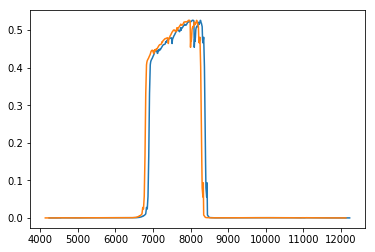

In [11]:
create_shifted_filter_set(original_filters_dir, filters_dir, filter_shifted, filter_shift)
compare_filters(original_filters_dir, filters_dir, filter_shifted)

### Recompute photometries for the reference sample using the shifted filter

In [12]:
r_shift_9_reference_photometry = '/tmp/nnpz_tests/Shift9ReferencePhotometry.fits'

In [13]:
rebuild_photometry(r_shift_9_reference_photometry, filters_dir)

/tmp/nnpz_tests/Shift9ReferencePhotometry.fits already exists, so skipping run


### Find "real" neighbours
Ok, so we have re-computed the photometry shifting the filter `r` by 100, which is the maximum shift value on the catalog
generated by Coupon.

We need now to run NNPZ using *only* bruteforce ($\chi^2$ distance) to find the best 30 against `r_shift_9` (which is shifted by 100).

To make things easier, we patch an existing configuration file.

In [14]:
real_output_file = os.path.join(output_dir, 'Shift9Real.fits')

In [15]:
nnpz_config = {}
with open(nnpz_original_config_file) as fd:
    exec(fd.read(), nnpz_config)

In [16]:
nnpz_config['reference_sample_dir'] = reference_sample
nnpz_config['reference_sample_phot_file'] = r_shift_9_reference_photometry
nnpz_config['target_catalog'] = target_catalog
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_shift9_obs', 'r_shift9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['target_catalog_filters_mean'] = None
nnpz_config['input_size'] = 10000 # To be changed
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = real_output_file
if 'pdz_mc_samples' in nnpz_config:
    del nnpz_config['pdz_mc_samples']

In [17]:
run_nnpz(nnpz_bin, nnpz_config, nnpz_env)

/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50/Shift9Real.fits already exists, so skipping run


0

### Compare combined neighbours with "real" neighbours
Pretty much same flow, but use the combined method, with 30 final neighbours, 1000 batch size.

In [18]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 50
combined_output_file = os.path.join(output_dir, 'Shift9Combined.fits')
nnpz_config['output_file'] = combined_output_file

In [19]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50/Shift9Combined.fits already exists, so skipping run
Took 0 seconds


In [20]:
combined = Table.read(combined_output_file)
real = Table.read(real_output_file)

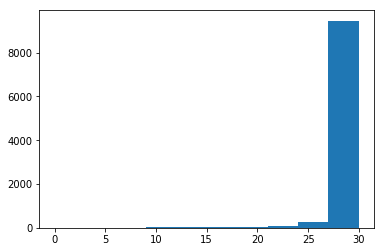

In [21]:
counts = plot_matching(real, combined)

In [22]:
counts[0]

3.0

## Same, but with skew
Let's use `r_skew`. We need to get its shift.

In [23]:
skew9_shift = get_filter_shift('r', 'r_skewing9')
print(skew9_shift)

57.0093


### Get "real" neighbours, using bruteforce and a recomputed photometry

In [24]:
r_skew_9_reference_photometry = '/tmp/nnpz_tests/Skew9ReferencePhotometry.fits'
skew9_filters_dir = '/tmp/nnpz_tests/Skew9Filters'

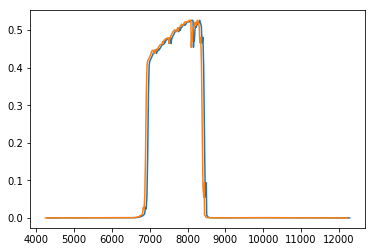

In [25]:
create_shifted_filter_set(original_filters_dir, skew9_filters_dir, 'r', skew9_shift)
compare_filters(original_filters_dir, skew9_filters_dir, filter_shifted)

In [26]:
rebuild_photometry(r_skew_9_reference_photometry, skew9_filters_dir)

/tmp/nnpz_tests/Skew9ReferencePhotometry.fits already exists, so skipping run


In [27]:
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_skewing9_obs', 'r_skewing9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['reference_sample_phot_file'] = r_skew_9_reference_photometry
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
skew9_output_file = os.path.join(output_dir, 'Skew9Real.fits')
nnpz_config['output_file'] = skew9_output_file

In [28]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50/Skew9Real.fits already exists, so skipping run
Took 0 seconds


### Skew, Combined

In [29]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 50
skew9_combined_output_file = os.path.join(output_dir, 'Skew9Combined.fits')
nnpz_config['output_file'] = skew9_combined_output_file

In [30]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50/Skew9Combined.fits already exists, so skipping run
Took 0 seconds


In [31]:
skew9_real = Table.read(skew9_output_file)
skew9_combined = Table.read(skew9_combined_output_file)

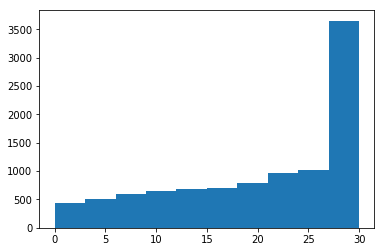

In [32]:
counts = plot_matching(skew9_real, skew9_combined)

In [33]:
counts[0]

132.0

### Skew, combined, 100

In [34]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 100
skew9_combined100_output_file = os.path.join(output_dir, 'Skew9Combined100.fits')
nnpz_config['output_file'] = skew9_combined100_output_file

duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift_50/Skew9Combined100.fits already exists, so skipping run
Took 0 seconds


In [35]:
skew9_combined100 = Table.read(skew9_combined100_output_file)

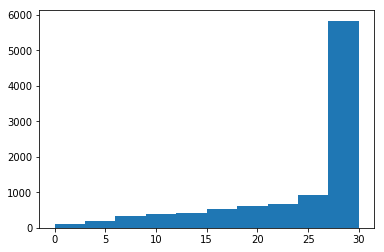

In [36]:
counts = plot_matching(skew9_real, skew9_combined100)

In [37]:
counts[0]

18.0